In [3]:
import json
import numpy as np
from pycocotools import mask
from skimage import measure
import os
import cv2

In [4]:
image_dir = "/home/fothar/rats/val_video_masks_gt_2020_04_29/img"
mask_dir = "/home/fothar/rats/val_video_masks_gt_2020_04_29/mask"
annotations_dir = "/home/fothar/rats/val_video_masks_gt_2020_04_29/annot"

via_annot = '/home/fothar/rats/val_video_masks_gt_2020_04_29/via_key.json'

image_url = 'http://nipg8.inf.elte.hu:8000/'

In [5]:
def imFunc(e):
  return int(e[:-4])

def maskFunc(e):
  return int(e[:-4])

In [ ]:
def new_via_project(project_name, with_parts=True):
    via_project = dict(_via_settings=
                   dict(ui=
                        dict(annotation_editor_height=25,
                             annotation_editor_fontsize=0.8,
                             leftsidebar_width=18,image_grid=
                                 dict(img_height=80,
                                      rshape_fill="none",
                                      rshape_fill_opacity=0.3,
                                      rshape_stroke="yellow",
                                      rshape_stroke_width=2,
                                      show_region_shape='true',
                                      show_image_policy="all"),
                             image=dict(region_label="instance_id",
                                        region_color="bodypart" if with_parts else "instance_id",
                                        region_label_font="10px Sans",
                                        on_image_annotation_editor_placement="NEAR_REGION")
                            ),
                        core=dict(buffer_size="18",filepath={},default_filepath=""),
                        project=dict(name=project_name)),
                   _via_img_metadata={},
                   _via_attributes=dict(region=dict(instance_id=dict(type="radio",description="",options={"1":"","2":""},default_options={})),
                                        file={}))
    if with_parts:
        via_project['_via_attributes']['region']['bodypart'] = dict(type="radio",description="",options={"head":"","body":"","tail":""},default_options={})
    return via_project
    


In [ ]:
images = {}
filenames = os.listdir(image_dir)
filenames.sort(key=imFunc)
valid_ids = [1, 2]
valid_parts = [1, 2, 3]

for_sem = True
via_project = new_via_project('easy', with_parts=True)

part_names = {1:'tail', 2:'body', 3:'head'}
for i, filename in enumerate(filenames):
    ann_image = dict(filename = image_url + filename,
                       size=-1,
                       regions=[],
                       file_attributes={})
    
    instance_mask = cv2.imread(os.path.join(annotations_dir, filename[:-4]+'_instances.png'),0)
    parts_mask = cv2.imread(os.path.join(annotations_dir, filename[:-4]+'_parts.png'),0)
    
    if for_sem:
        for inst_id in valid_ids: 
            for part_id in valid_parts:


                ground_truth_binary_mask = (parts_mask==part_id).astype(np.uint8)
                ground_truth_binary_mask[instance_mask!=inst_id] = 0

                fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
                encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
                ground_truth_area = mask.area(encoded_ground_truth)
                ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
                contours = measure.find_contours(ground_truth_binary_mask, 0.5)

                shape_attributes = dict(name="polygon", all_points_x = [], all_points_y = [])
                region_attributes = dict(bodypart = part_names[part_id], instance_id=inst_id)

                if contours:
                    contour = contours[0]

                    #for _ in range(2):
                    #    contour = measure.subdivide_polygon(contour, degree=2, preserve_ends=True)

                    # approximate subdivided polygon with Douglas-Peucker algorithm
                    contour = measure.approximate_polygon(contour, tolerance=2)


                    all_points_x = contour[:, 1]
                    all_points_y = contour[:, 0]

                    shape_attributes['all_points_x'] = all_points_x.tolist()                
                    shape_attributes['all_points_y'] = all_points_y.tolist()

                ann_image['regions'].append(dict(shape_attributes=shape_attributes, region_attributes=region_attributes))
        
    images[image_url + filename]  = ann_image
    
via_project['_via_img_metadata'] = images



In [3]:
image_root_dir = "/home/fothar/rats/test_videos"
mask_root_dir = "/home/fothar/rats/test_masks"

via_annot_dir = '/home/fothar/rats/test_annot'

image_url = 'http://nipg8.inf.elte.hu:8001/'

In [9]:
scenes = os.listdir(image_root_dir)
for_sem = True
for scene in scenes:
    images = {}
    filenames = os.listdir(os.path.join(image_root_dir, scene))
    filenames.sort(key=imFunc)
    project_name = 'hard_' + scene + 'key' if not for_sem
    
    via_project = new_via_project(project_name, with_parts=False)
    
    for i, filename in enumerate(filenames):
        url = image_url + '/' +scene+ '/' +filename
        ann_image = dict(filename = url,
                           size=-1,
                           regions=[],
                           file_attributes={})

        instance_mask = cv2.imread(os.path.join(mask_root_dir, scene, filename),0)
        
        valid_ids = np.unique(instance_mask)[1:]
        
        if for_sem:
            for eid, inst_id in enumerate(valid_ids): 

                ground_truth_binary_mask = (instance_mask==inst_id).astype(np.uint8)
                
                if np.sum(ground_truth_binary_mask) > 0:

                    fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
                    encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
                    ground_truth_area = mask.area(encoded_ground_truth)
                    ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
                    contours = measure.find_contours(ground_truth_binary_mask, 0.5)

                    shape_attributes = dict(name="polygon", all_points_x = [], all_points_y = [])
                    region_attributes = dict(instance_id=eid + 1)

                    if contours:
                        contour = contours[0]

                        #for _ in range(2):
                        #    contour = measure.subdivide_polygon(contour, degree=2, preserve_ends=True)

                        # approximate subdivided polygon with Douglas-Peucker algorithm
                        contour = measure.approximate_polygon(contour, tolerance=2)


                        all_points_x = contour[:, 1]
                        all_points_y = contour[:, 0]

                        shape_attributes['all_points_x'] = all_points_x.tolist()                
                        shape_attributes['all_points_y'] = all_points_y.tolist()

                    ann_image['regions'].append(dict(shape_attributes=shape_attributes, region_attributes=region_attributes))

        images[url]  = ann_image

    via_project['_via_img_metadata'] = images
    with open(os.path.join(via_annot_dir, project_name + '.json'), 'w') as outfile:
        json.dump(via_project, outfile)

    


In [ ]:
image_root_dir = "/media/hdd/aron/rats/test_videos"
mask_root_dir = "/media/hdd/aron/rats/test_masks"

via_annot_dir = '/home/fothar/rats/test_annot'

image_url = 'http://nipg8.inf.elte.hu:8001/'

In [ ]:
scenes = os.listdir(image_root_dir)
for_sem = True
for scene in scenes:
    images = {}
    filenames = os.listdir(os.path.join(image_root_dir, scene))
    filenames.sort(key=imFunc)
    project_name = 'hard_' + scene + 'key' if not for_sem
    
    via_project = new_via_project(project_name, with_parts=False)
    
    for i, filename in enumerate(filenames):
        url = image_url + '/' +scene+ '/' +filename
        ann_image = dict(filename = url,
                           size=-1,
                           regions=[],
                           file_attributes={})

        instance_mask = cv2.imread(os.path.join(mask_root_dir, scene, filename),0)
        
        valid_ids = np.unique(instance_mask)[1:]
        
        if for_sem:
            for eid, inst_id in enumerate(valid_ids): 

                ground_truth_binary_mask = (instance_mask==inst_id).astype(np.uint8)
                
                if np.sum(ground_truth_binary_mask) > 0:

                    fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
                    encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
                    ground_truth_area = mask.area(encoded_ground_truth)
                    ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
                    contours = measure.find_contours(ground_truth_binary_mask, 0.5)

                    shape_attributes = dict(name="polygon", all_points_x = [], all_points_y = [])
                    region_attributes = dict(instance_id=eid + 1)

                    if contours:
                        contour = contours[0]

                        #for _ in range(2):
                        #    contour = measure.subdivide_polygon(contour, degree=2, preserve_ends=True)

                        # approximate subdivided polygon with Douglas-Peucker algorithm
                        contour = measure.approximate_polygon(contour, tolerance=2)


                        all_points_x = contour[:, 1]
                        all_points_y = contour[:, 0]

                        shape_attributes['all_points_x'] = all_points_x.tolist()                
                        shape_attributes['all_points_y'] = all_points_y.tolist()

                    ann_image['regions'].append(dict(shape_attributes=shape_attributes, region_attributes=region_attributes))

        images[url]  = ann_image

    via_project['_via_img_metadata'] = images
    with open(os.path.join(via_annot_dir, project_name + '.json'), 'w') as outfile:
        json.dump(via_project, outfile)

    


# vis3youtube

In [ ]:

vis_annotation_path = '/home/fothar/rat_annotation/done/vis/'
vis_annotations = os.listdir(vis_annotation_path)

for vis_annotation in vis_annotations:
            
    with open(os.path.join(vis_annotation_path, vis_annotation)) as json_file:
        data = json.load(json_file)
        print(data.keys())
        print(data['_via_img_metadata']['http://nipg8.inf.elte.hu:8001//101/0.png'].keys())
        print(data['_via_img_metadata']['http://nipg8.inf.elte.hu:8001//101/0.png']['filename'])
        print(data['_via_img_metadata']['http://nipg8.inf.elte.hu:8001//101/0.png']['regions'])
        asd

    
    

In [6]:
rat_info = dict(description= 'Rats', url= 'https://rats.org/home', version= '0.1', year= 2020, contributor= 'ELTE', date_created= '2020-01-11 00:55:41.903634')
rat_licenses = [dict(url= 'https://creativecommons.org/licenses/by/4.0/', id= 1, name= 'Creative Commons Attribution 4.0 License')]
rat_categories = [dict(supercategory= 'object', id= 1, name ='rat')]

In [82]:
from skimage import io

image_path_root = "/media/hdd/aron/rats/human/"

os.makedirs(image_path_root, exist_ok=True)

vis_annotation_path = '/home/fothar/rat_annotation/done/vis/'
vis_annotations = os.listdir(vis_annotation_path)
vid_id = 1    
ann_id = 1
rat_data = dict(info=rat_info, 
                    licenses=rat_licenses,
                    categories=rat_categories,
                    videos=[],
                    annotations=[])
for vis_annotation in vis_annotations[:1]:
    image_path = os.path.join(image_path_root, vis_annotation.split('.')[0])
    os.makedirs(image_path, exist_ok=True)
            
    with open(os.path.join(vis_annotation_path, vis_annotation)) as json_file:
        data = json.load(json_file)
        
        image_data = data['_via_img_metadata']
        img = io.imread([*image_data][0])
        video = dict(width= img.shape[1],
                         length= len(image_data),
                         date_captured= '',
                         license= '',
                         flickr_url= '',
                         file_name= img_path,
                         id= vid_id,
                         coco_url= '',
                         height=img.shape[0])
        
        ann_1 = dict(height= img.shape[0],
                     width= img.shape[1],
                     length= 1,
                     category_id= 1,
                     segmentations= [],
                     bboxes= [],
                     video_id= vid_id,
                     iscrowd= False,
                     id= ann_id,
                     areas= [])        
        ann_id += 1
        
        ann_2 = dict(height= img.shape[0],
                     width= img.shape[1],
                     length= 1,
                     category_id= 1,
                     segmentations= [],
                     bboxes= [],
                     video_id= vid_id,
                     iscrowd= False,
                     id= ann_id,
                     areas= [])
        ann_id += 1
        
        ann_dict = {1:ann_1, 2:ann_2}
        
        for im_url in image_data:   
            
            img = io.imread(im_url)
            img_path = os.path.join(image_path, im_url.split('/')[-1])
            io.imsave(img_path, img)
            
            regions = image_data[im_url]['regions']
            instance_contours = {1:[], 2:[]}
            for region in regions:               

                
                contour_x = region['shape_attributes']['all_points_x']
                contour_y = region['shape_attributes']['all_points_y']
                contour = [j for i in zip(contour_x,contour_y) for j in i]
                inst_id = region['region_attributes']['instance_id']
                instance_contours[int(inst_id)].append(contour)
                
            for inst_id, contours in instance_contours.items():
                
                rles = mask.frPyObjects(contours,img.shape[0],img.shape[1])
            
                rle = mask.merge(rles)
                area = mask.area(rle)
                bounding_box = mask.toBbox(rle)

                ann_dict[inst_id]['bboxes'].append(bounding_box.tolist())
                ann_dict[inst_id]['areas'].append(int(area))


                rle['counts'] = rle['counts'].decode('ascii')
            
            
                
                ann_dict[inst_id]['segmentations'].append(rle)
                
        for _, ann in ann_dict.items():
            rat_data['annotations'].append(ann)   
        

    vid_id += 1
    rat_data['videos'].append(video)


In [40]:
instance_mask = cv2.imread(os.path.join('/media/hdd/aron/rats/auto/500/masks/20.png'),0)
im_id = 1    
ann_id = 1
valid_ids = np.unique(instance_mask)[1:]

rat_data = dict(info=rat_info, 
                    licenses=rat_licenses,
                    categories=rat_categories,
                    images=[],
                    annotations=[])

image = dict(width= instance_mask.shape[1],
             length= 1, #vid_idx[1]-vid_idx[0],
             date_captured= '',
             license= '',
             flickr_url= '',
             file_name= [],
             id= im_id,
             coco_url= '',
             height=instance_mask.shape[0])



for eid, inst_id in enumerate(valid_ids): 

    ground_truth_binary_mask = (instance_mask==inst_id).astype(np.uint8)

    if np.sum(ground_truth_binary_mask) > 0:
        
        ann = dict(height= instance_mask.shape[0],
             width= instance_mask.shape[1],
             category_id= 1,
             segmentation= [],
             bbox= [],
             image_id= im_id,
             iscrowd= False,
             id= ann_id,
             area= [])

        fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
        encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
        ground_truth_area = mask.area(encoded_ground_truth)
        ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
        contours = measure.find_contours(ground_truth_binary_mask, 0.5)        

        if contours:
            contour = contours[0]
            contour = measure.approximate_polygon(contour, tolerance=2)
            contour = np.fliplr(contour)
            contour = contour.flatten()
            contour = [contour.tolist()]#, contour[:, 1].tolist()]
            rles = mask.frPyObjects(contour,instance_mask.shape[0],instance_mask.shape[1])
            rle = mask.merge(rles)
            area = mask.area(rle)
            bounding_box = mask.toBbox(rle)
            
            ann['bbox'] = bounding_box.tolist()
            ann['area'] = int(area)
    
    
            rle['counts'] = rle['counts'].decode('ascii')
            ann['segmentation'] = rle
        rat_data['annotations'].append(ann)   
        ann_id += 1
        
rat_data['images'].append(image)

In [61]:
from skimage import io

image_path_root = "/media/hdd/aron/rats/human/"

os.makedirs(image_path_root, exist_ok=True)

vis_annotation_path = '/home/fothar/rat_annotation/done/vis/'
vis_annotations = os.listdir(vis_annotation_path)
im_id = 1    
ann_id = 1
rat_data = dict(info=rat_info, 
                    licenses=rat_licenses,
                    categories=rat_categories,
                    images=[],
                    annotations=[])
for vis_annotation in vis_annotations[:1]:
    image_path = os.path.join(image_path_root, vis_annotation.split('.')[0])
    os.makedirs(image_path, exist_ok=True)
            
    with open(os.path.join(vis_annotation_path, vis_annotation)) as json_file:
        data = json.load(json_file)
        
        image_data = data['_via_img_metadata']
        for im_url in image_data:   
            
            img = io.imread(im_url)
            img_path = os.path.join(image_path, im_url.split('/')[-1])
            io.imsave(img_path, img)

            image = dict(width= img.shape[1],
                         length= 1, #vid_idx[1]-vid_idx[0],
                         date_captured= '',
                         license= '',
                         flickr_url= '',
                         file_name= img_path,
                         id= im_id,
                         coco_url= '',
                         height=img.shape[0])
            
            regions = image_data[im_url]['regions']
            instance_contours = {1:[], 2:[]}
            for region in regions:               

                
                contour_x = region['shape_attributes']['all_points_x']
                contour_y = region['shape_attributes']['all_points_y']
                contour = [j for i in zip(contour_x,contour_y) for j in i]
                inst_id = region['region_attributes']['instance_id']
                instance_contours[int(inst_id)].append(contour)
                
            for inst_id, contours in instance_contours.items():
                
                rles = mask.frPyObjects(contours,img.shape[0],img.shape[1])
            
                rle = mask.merge(rles)
                area = mask.area(rle)
                bounding_box = mask.toBbox(rle)

                ann['bbox'] = bounding_box.tolist()
                ann['area'] = int(area)


                rle['counts'] = rle['counts'].decode('ascii')
            
            
                ann = dict(height= instance_mask.shape[0],
                     width= instance_mask.shape[1],
                     category_id= 1,
                     segmentation= [],
                     bbox= [],
                     image_id= im_id,
                     iscrowd= False,
                     id= ann_id,
                     area= [])
                ann['segmentation'] = rle
                rat_data['annotations'].append(ann)   
                ann_id += 1

            im_id += 1
            rat_data['images'].append(image)
        
        

In [83]:
coco_ann_file = '/media/hdd/aron/rats/auto/instances_test.json'
with open(coco_ann_file, 'w') as outfile:
    json.dump(rat_data, outfile)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
{'width': 640, 'length': 1, 'date_captured': '', 'license': '', 'flickr_url': '', 'file_name': '/media/hdd/aron/rats/human/hard_101_fin.json/140.png', 'id': 141, 'coco_url': '', 'height': 420}


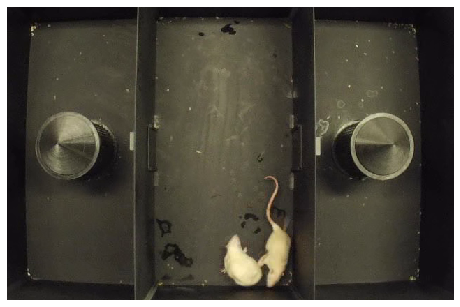

In [76]:
%matplotlib inline

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

from pycocotools.coco import COCO
coco_ann_file = '/media/hdd/aron/rats/auto/instances_test.json'
coco=COCO(coco_ann_file)
imgIds = coco.getImgIds()

img = coco.loadImgs(imgIds[140])[0]

print(img)

I = io.imread(img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

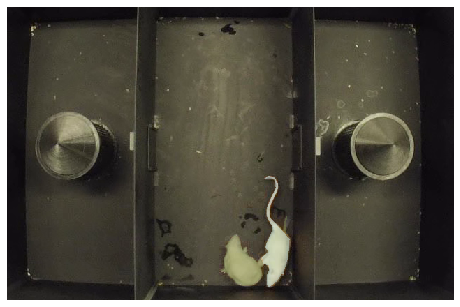

In [77]:

plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'])
anns = coco.loadAnns(annIds)
coco.showAnns(anns)